In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools, viz_tools)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [54]:
f = pd.read_excel('/ocean/eolson/MEOPAR/obs/PSFCitSci/PSF 2017 Chla_Data_Final_v-January 22-2018_CN_edits.xlsx',
                  sheetname=2, header=13)

In [55]:
f = f.drop(f.index[:2])
f.head()

,Date sampled,Ship/Boat,Station,Unnamed: 3,depth,Chl a,Chl a.1,CV%,quality,Phaeophytin,Phaeophytin.1,Unnamed: 11
1.0,2017-03-02 00:00:00,CTL,BS-1,13:28:00,5,2.00828,2.0514,2.97282,NaN,0.449706,0.49671,NaN
1.0,2017-03-02 00:00:00,CTL,BS-1,13:28:00,5,2.09452,NaN,NaN,NaN,0.543713,NaN,NaN
1.0,2017-06-13 00:00:00,CTL,BS-1,17:50:00,5,1.34296,1.33064,1.30946,NaN,0.508723,0.504657,NaN
1.0,2017-06-13 00:00:00,CTL,BS-1,17:50:00,5,1.31832,NaN,NaN,NaN,0.500591,NaN,NaN
1.0,2017-04-25 00:00:00,CTL,BS-1,17:55:00,5,15.7705,15.4625,2.81716,NaN,1.76309,1.66145,NaN


In [56]:
f.shape

(357, 12)

In [57]:
f = f.dropna(subset=['Date sampled', 'Station', 'Unnamed: 3', 'depth', 'Chl a'])
f.shape

(331, 12)

In [58]:
f = f[f['quality'] != 4]
f = f[f['quality'] != 3]

In [59]:
f.shape

(292, 12)

In [14]:
g = pd.read_csv('/ocean/eolson/MEOPAR/obs/PSFCitSci/2016ChlorophyllStationData.csv')

In [40]:
stations = {}
for station in g.Station.unique():
    stations[station] = np.array([g[g.Station == station][:1].Longitude.values[0], 
                                  g[g.Station == station][:1].Latitude.values[0]])

In [43]:
stations['BS-1'] = np.array([-124.8666667, 49.6083333])
stations['IS-4'] = np.array([-124.155, 49.575])
stations['CBC-1'] = np.array([-123.605, 48.74])
stations['CBC-3'] = np.array([-123.605, 48.755])
stations['NQ-4'] = np.array([-124.108333, 49.46167])
stations['ST-7'] = np.array([-123.405, 49.278333])
stations['NQ-7'] = np.array([-124.174771067, 49.3326498429])
stations['ST-8'] = stations['SN-8']

In [44]:
local = pytz.timezone ("America/Los_Angeles")

In [46]:
f.shape

(292, 12)

In [60]:
f2 = pd.DataFrame({'Date': f['Date sampled'].values,
                   'Station': f.Station.values,
                   'Time': f['Unnamed: 3'].values,
                   'Depth': f.depth.values,
                   'Chl': f['Chl a'].values})

In [79]:
f2 = f2[f2.Station != 'CB-SN-1']

In [80]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_chl = np.array([])
list_of_model_chl = np.array([])
for n in f2.index:
    Lat = stations[f2.Station[n]][1]
    Lon = stations[f2.Station[n]][0]
    Yind, Xind = geo_tools.find_closest_model_point(Lon, Lat, X, Y, land_mask = bathy.mask)
    if mesh.variables['tmask'][0,4,Yind, Xind] == 1:
        local_datetime = (datetime.datetime.combine(pd.to_datetime(f2.Date[n]),
                                                    f2.Time[n]))
        date = local.localize(local_datetime, is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 4, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,4,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,4,Yind,Xind]) + 
                       (1- delta)*(nuts2.variables['diatoms'][after.hour, 4, Yind, Xind] 
                           + nuts2.variables['ciliates'][after.hour,4,Yind, Xind] 
                           + nuts2.variables['flagellates'][after.hour,4,Yind,Xind]))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 4, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,4,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,4,Yind,Xind]) + 
                       (1- delta)*(nuts2.variables['diatoms'][after.hour, 4, Yind, Xind] 
                           + nuts2.variables['ciliates'][after.hour,4,Yind, Xind] 
                           + nuts2.variables['flagellates'][after.hour,4,Yind,Xind]))
        list_of_lons = np.append(list_of_lons, Lon)
        list_of_lats = np.append(list_of_lats, Lat)
        list_of_datetimes = np.append(list_of_datetimes, date)
        list_of_cs_chl = np.append(list_of_cs_chl, f2.Chl[n])
        list_of_model_chl = np.append(list_of_model_chl, chl_val)

In [10]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12

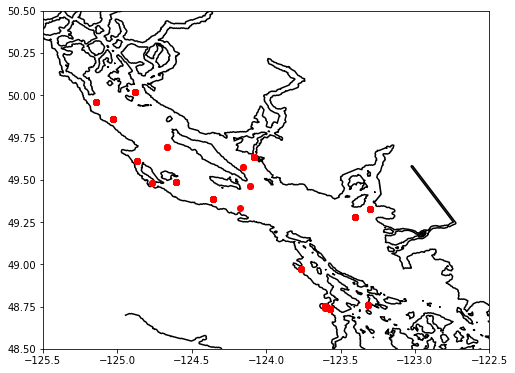

In [82]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.5, 50.5)
ax.set_xlim(-125.5, -122.5);

In [83]:
list_of_cs_chl.shape

(291,)

bias =  0.576055578713
RMSE = 4.02078955168
Willmott = 0.523428341776


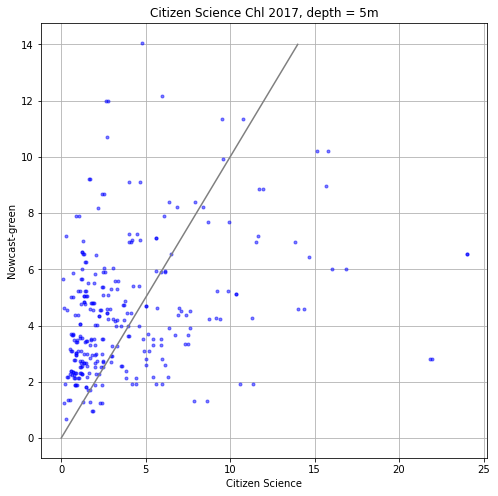

In [90]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(list_of_cs_chl, list_of_model_chl,  'b.', alpha = 0.5)
ax.plot(np.arange(0,15), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Chl 2017, depth = 5m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(list_of_cs_chl) + np.mean(list_of_model_chl)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl - list_of_cs_chl)**2) /
                              len(list_of_cs_chl))))
xbar = np.mean(list_of_cs_chl)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl - list_of_cs_chl)**2)  / 
                             np.sum((np.abs(list_of_model_chl - xbar) 
                                     + np.abs(list_of_cs_chl - xbar))**2))))

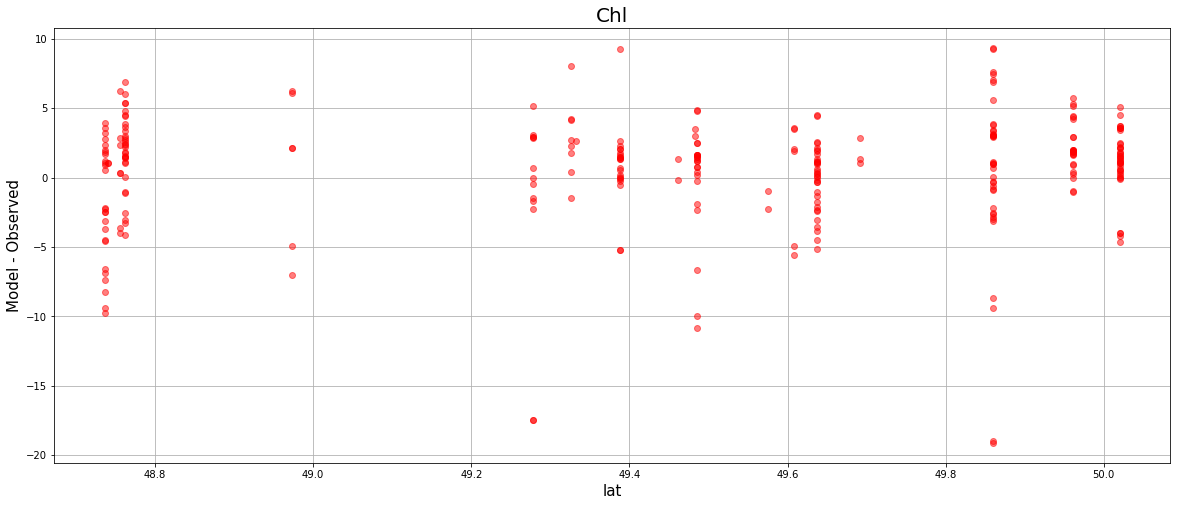

In [86]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20);

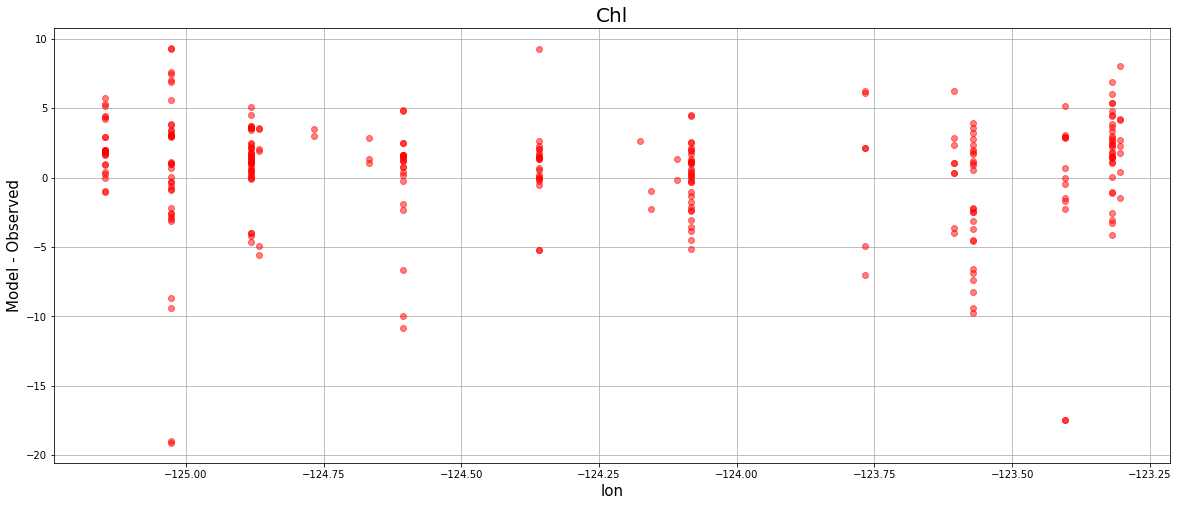

In [87]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20);

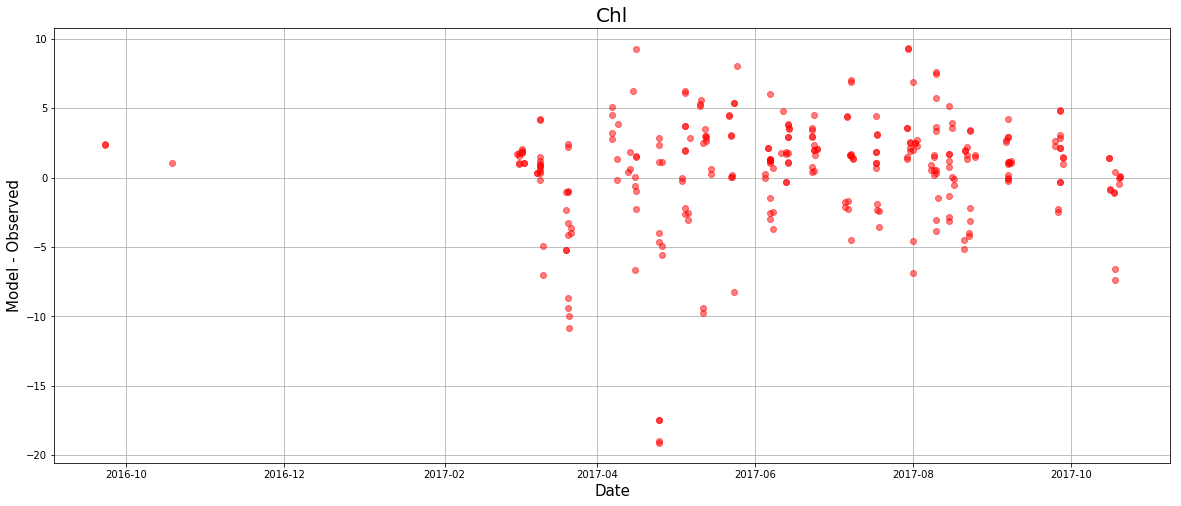

In [88]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes, list_of_model_chl - list_of_cs_chl, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20);